In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('base_segmentacao_202301_treinamento.csv')

In [3]:
#Volume com duplicados
df.shape

(373417, 21)

In [4]:
#Quantidade de linhas depois de remover duplicados
df.drop_duplicates(subset=['num_adm'], inplace=True)
df.shape[0]

373137

In [5]:
#Removendo linhas de pessoas que foram cobradas mais de R$3000 nos últimos 3 meses
df = df.loc[df['total_cobrado_u3m']< 3000]

### Separação por Cluster

Critérios iniciais:

Percentual de faturas pagas (valor), Percentual do CAC que o cliente paga em 3 meses, Qtd de OS e protocolos


In [6]:
def gerar_segmentacao(df):
    df = df.fillna(0)
    conditions = [
        (df['perc_pago_cobrado_valor'] < 40),
        (df['perc_pago_cobrado_valor'] >= 40) & (df['perc_pago_cobrado_valor'] < 70),
        (df['perc_pago_cobrado_valor'] >= 70) & (df['perc_pago_cobrado_valor'] < 90),
        (df['perc_pago_cobrado_valor'] >= 90)
    ]
    cluster_values = [1, 2, 3, 4]
    df['cluster_perc_pago'] = np.select(conditions, cluster_values, default='Outro')
    df['cluster_perc_pago'] =  df['cluster_perc_pago'].astype('int64')

    #Pagamento do CAC
    conditions = [
        (df['perc_pago_do_custo_1000'] < 20),
        (df['perc_pago_do_custo_1000'] >= 20) & (df['perc_pago_do_custo_1000'] < 30),
        (df['perc_pago_do_custo_1000'] >= 30) & (df['perc_pago_do_custo_1000'] < 50),
        (df['perc_pago_do_custo_1000'] >= 50)
    ]
    cluster_values = [1, 2, 3, 4]
    df['cluster_pago_do_custo'] = np.select(conditions, cluster_values, default='Outro')
    df['cluster_pago_do_custo'] =  df['cluster_pago_do_custo'].astype('int64')

    ## Ordem de serviço
    conditions = [
        (df['qtd_os_finalizadas_u3m'] < 1 ),
        (df['qtd_os_finalizadas_u3m'] >= 1) & (df['qtd_os_finalizadas_u3m'] <= 2),
        (df['qtd_os_finalizadas_u3m'] == 3),
        (df['qtd_os_finalizadas_u3m'] > 3)
    ]
    cluster_values = [4, 3, 2, 1]
    df['cluster_OS'] = np.select(conditions, cluster_values, default='Outro')
    df['cluster_OS'] = df['cluster_OS'].astype('int64')

    ##Protocolos
    conditions = [
        (df['qtd_protocolos_u3m'] < 1),
        (df['qtd_protocolos_u3m'] >= 1) & (df['qtd_protocolos_u3m'] <= 2),
        (df['qtd_protocolos_u3m'] == 3),
        (df['qtd_protocolos_u3m'] > 3)
    ]
    cluster_values = [4, 3, 2, 1]
    df['cluster_protocolos'] = np.select(conditions, cluster_values, default='Outro')
    df['cluster_protocolos'] =  df['cluster_protocolos'].astype('int64')

    #Soma final
    df['pontuacao'] = df['cluster_perc_pago'] + df['cluster_pago_do_custo'] + df['cluster_OS'] + df['cluster_protocolos']
    return df


In [7]:
df = gerar_segmentacao(df)

In [8]:
df['pontuacao'].value_counts().reset_index().sort_values('pontuacao')

,pontuacao,count
10,6,18
9,7,84
8,8,520
6,9,3914
5,10,26986
3,11,36591
2,12,58896
4,13,33696
1,14,101216
0,15,105080


In [9]:
df.head()

,num_adm,ativo,meses_base_cadastro,meses_de_base_entre_3_e_6_meses,meses_de_base_entre_6_e_12_meses,meses_de_base_entre_12_e_24_meses,meses_de_base_maior_24,qtd_faturas_cobradas_u3m,qtd_faturas_pagas_u3m,possui_desconto,soma_desconto,perc_pago_cobrado_qtd,total_cobrado_u3m,total_pago_u3m,total_pago_maior_300,total_cobrado_maior_300,perc_pago_cobrado_valor,perc_pago_do_custo_1000,qtd_os_finalizadas_u3m,qtd_protocolos_u3m,target,cluster_perc_pago,cluster_pago_do_custo,cluster_OS,cluster_protocolos,pontuacao
0,678059,868171,20,0,0,1,0,3.0,3.0,1,-11.76,100,317.94,317.94,1,1,100.000000,31.794,0,0,0,4,3,4,4,15
1,476936,536804,20,0,0,1,0,3.0,3.0,0,0.00,100,389.70,394.60,1,1,101.257377,39.460,0,0,0,4,3,4,4,15
2,783415,1022108,6,1,0,0,0,3.0,2.0,0,0.00,0,299.70,199.80,0,0,66.666667,19.980,0,0,0,2,1,4,4,11
3,398234,360901,27,0,0,0,1,3.0,3.0,0,0.00,100,389.70,397.40,1,1,101.975879,39.740,0,0,0,4,3,4,4,15
4,606517,759978,12,0,1,0,0,3.0,3.0,1,-105.00,100,252.21,257.81,0,0,102.220372,25.781,3,0,0,4,2,2,4,12


In [10]:
regras = [(df['pontuacao'] >= 15) & (df['pontuacao'] <= 16) & (df['meses_base_cadastro'] > 24),
          (df['pontuacao'] >= 13) & (df['pontuacao'] <= 14),
          (df['pontuacao'] >= 4) & (df['pontuacao'] <= 12)]

cluster_values = ['Alto Valor', 'Médio Valor', 'Baixo Valor']

df['cluster'] = np.select(regras, cluster_values, default='Alto Valor - Jovem')

### Volumetria por cluster

In [11]:
df.groupby('cluster')['num_adm'].count()

cluster
Alto Valor             44100
Alto Valor - Jovem     64802
Baixo Valor           127009
Médio Valor           134912
Name: num_adm, dtype: int64

In [12]:
df.loc[df['cluster']=='Baixo Valor'].sample()

,num_adm,ativo,meses_base_cadastro,meses_de_base_entre_3_e_6_meses,meses_de_base_entre_6_e_12_meses,meses_de_base_entre_12_e_24_meses,meses_de_base_maior_24,qtd_faturas_cobradas_u3m,qtd_faturas_pagas_u3m,possui_desconto,soma_desconto,perc_pago_cobrado_qtd,total_cobrado_u3m,total_pago_u3m,total_pago_maior_300,total_cobrado_maior_300,perc_pago_cobrado_valor,perc_pago_do_custo_1000,qtd_os_finalizadas_u3m,qtd_protocolos_u3m,target,cluster_perc_pago,cluster_pago_do_custo,cluster_OS,cluster_protocolos,pontuacao,cluster
142241,778000,1180243,5,1,0,0,0,3.0,3.0,1,-40.0,100,259.7,267.4,0,0,102.96496,26.74,2,1,0,4,2,3,3,12,Baixo Valor


### Resumo dos dados de cada cluster

In [13]:
lista = ['meses_base_cadastro','qtd_faturas_cobradas_u3m',
       'qtd_faturas_pagas_u3m', 'total_cobrado_u3m',
       'total_pago_u3m', 'qtd_os_finalizadas_u3m',
       'qtd_protocolos_u3m']
df.groupby('cluster')[lista].mean().T

cluster,Alto Valor,Alto Valor - Jovem,Baixo Valor,Médio Valor
meses_base_cadastro,55.855692,12.828107,25.936201,30.160875
qtd_faturas_cobradas_u3m,3.001701,3.003657,2.883237,2.924277
qtd_faturas_pagas_u3m,3.000658,3.002484,1.728720,2.868366
total_cobrado_u3m,363.684680,350.834893,305.628938,288.712602
total_pago_u3m,365.819148,354.190725,180.898048,282.829571
qtd_os_finalizadas_u3m,0.012517,0.008055,0.280405,0.324604
qtd_protocolos_u3m,0.002676,0.002052,0.088317,0.060091


In [14]:
lista = ['qtd_os_finalizadas_u3m',
       'qtd_protocolos_u3m']
df.groupby('cluster')[lista].mean().sort_values('qtd_os_finalizadas_u3m')

,qtd_os_finalizadas_u3m,qtd_protocolos_u3m
cluster,,
Alto Valor - Jovem,0.008055,0.002052
Alto Valor,0.012517,0.002676
Baixo Valor,0.280405,0.088317
Médio Valor,0.324604,0.060091


In [15]:
grupo = df.groupby('cluster')[['total_pago_u3m', 'total_cobrado_u3m','qtd_faturas_cobradas_u3m','qtd_faturas_pagas_u3m']].sum()
resultado_perc_pago = grupo['total_pago_u3m'] / grupo['total_cobrado_u3m']
resultado_perc_pago_quantidade = grupo['qtd_faturas_pagas_u3m'] / grupo['qtd_faturas_cobradas_u3m']

resultado_df = pd.DataFrame({'Resultado_Perc_Pago_valor': resultado_perc_pago, 
                            'Resultado_Perc_Pago_Quantidade': resultado_perc_pago_quantidade})
resultado_df = resultado_df.reset_index()
resultado_df.sort_values('Resultado_Perc_Pago_valor')


,cluster,Resultado_Perc_Pago_valor,Resultado_Perc_Pago_Quantidade
2,Baixo Valor,0.591888,0.599576
3,Médio Valor,0.979623,0.980881
0,Alto Valor,1.005869,0.999653
1,Alto Valor - Jovem,1.009565,0.999610


In [16]:
df_teste = df.groupby('cluster').agg({'total_pago_u3m': 'sum', 'num_adm': 'count'}).reset_index()
df_teste = df_teste.rename(columns={'total_pago_u3m': 'total_pago_u3m_sum', 'num_adm': 'contagem'})

df_teste['CAC'] = df_teste['contagem'] * 1000

df_teste['percentual_pago_CAC'] = df_teste['total_pago_u3m_sum'] / df_teste['CAC']   

df_teste = df_teste.sort_values('percentual_pago_CAC', ascending= False)
df_teste


,cluster,total_pago_u3m_sum,contagem,CAC,percentual_pago_CAC
0,Alto Valor,16132624.43,44100,44100000,0.365819
1,Alto Valor - Jovem,22952267.38,64802,64802000,0.354191
3,Médio Valor,38157103.08,134912,134912000,0.282830
2,Baixo Valor,22975680.17,127009,127009000,0.180898


## Cobrança e Pagamento

### Total Cobrado (Valor)

In [17]:
df.loc[df['num_adm']== 100505]

,num_adm,ativo,meses_base_cadastro,meses_de_base_entre_3_e_6_meses,meses_de_base_entre_6_e_12_meses,meses_de_base_entre_12_e_24_meses,meses_de_base_maior_24,qtd_faturas_cobradas_u3m,qtd_faturas_pagas_u3m,possui_desconto,soma_desconto,perc_pago_cobrado_qtd,total_cobrado_u3m,total_pago_u3m,total_pago_maior_300,total_cobrado_maior_300,perc_pago_cobrado_valor,perc_pago_do_custo_1000,qtd_os_finalizadas_u3m,qtd_protocolos_u3m,target,cluster_perc_pago,cluster_pago_do_custo,cluster_OS,cluster_protocolos,pontuacao,cluster
183090,100505,166834,87,0,0,0,1,3.0,3.0,0,0.0,100,299.7,301.91,1,0,100.737404,30.191,1,0,0,4,3,3,4,14,Médio Valor


In [18]:
df.groupby('cluster')[['total_cobrado_u3m']].describe()

total_cobrado_u3m                                         \
                               count        mean        std     min     25%   
cluster                                                                       
Alto Valor                   44100.0  363.684680  92.652442  199.80  317.94   
Alto Valor - Jovem           64802.0  350.834893  75.824503  149.90  299.70   
Baixo Valor                 127009.0  305.628938  76.323064    0.00  269.70   
Médio Valor                 134912.0  288.712602  77.654469    5.18  259.70   

                                            
                      50%     75%      max  
cluster                                     
Alto Valor          329.7  389.70  1529.70  
Alto Valor - Jovem  329.7  389.70  1589.70  
Baixo Valor         299.7  343.05  1655.13  
Médio Valor         284.7  299.70  2249.85

In [19]:
df.groupby('cluster')[['total_pago_u3m']].describe()

total_pago_u3m                                         \
                            count        mean        std     min     25%   
cluster                                                                    
Alto Valor                44100.0  365.819148  92.137571  300.00  317.94   
Alto Valor - Jovem        64802.0  354.190725  75.087559  300.00  304.90   
Baixo Valor              127009.0  180.898048  81.434733    0.00  159.80   
Médio Valor              134912.0  282.829571  60.438431    5.18  261.77   

                                           
                      50%    75%      max  
cluster                                    
Alto Valor          332.2  389.7  1540.04  
Alto Valor - Jovem  330.8  389.7  1589.70  
Baixo Valor         203.3  226.7  1169.70  
Médio Valor         283.7  299.7  2249.85

In [20]:
# Mapeie clusters para as paletas correspondentes
pal = {
    'Baixo Valor': '#FF4136',
    'Médio Valor': '#B10DC9',
    'Alto Valor': '#2ECC40',
    'Alto Valor - Jovem': '#0074D9'
}


In [21]:
pl = sns.scatterplot(data = df,x=df["total_cobrado_u3m"], y=df["total_pago_u3m"],hue=df["cluster"], palette= pal)
pl.set_title("Valor total pago e cobrado por cluster")
plt.legend()

plt.show()

KeyboardInterrupt: 

### Quantidade Cobrada e Pago


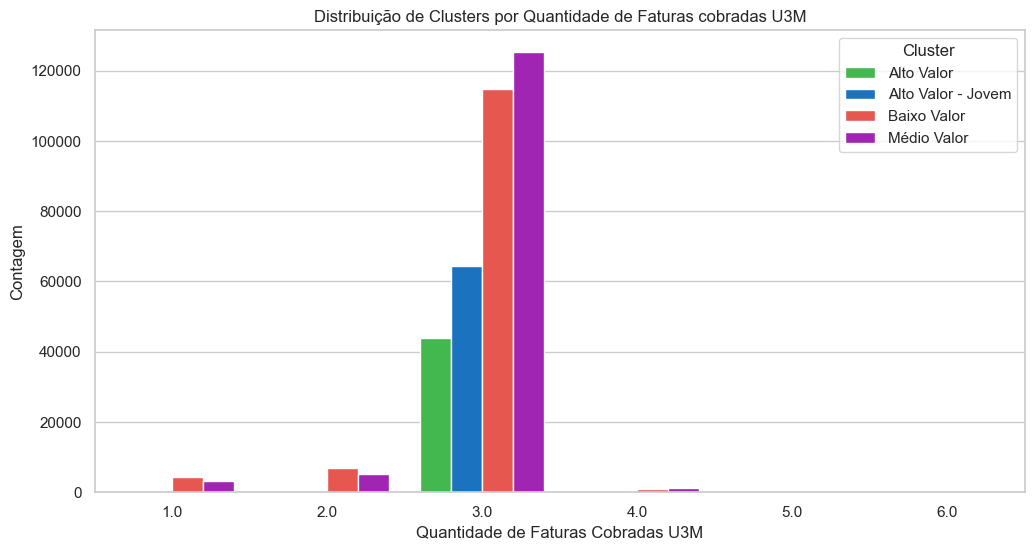

In [ ]:
# Crie um gráfico de barras empilhadas
sns.set(style="whitegrid")

# Agrupe os dados pelo cluster e conte as ocorrências em cada categoria de "qtd_faturas_pagas_u3m"
cluster_counts = df.groupby(['qtd_faturas_cobradas_u3m', 'cluster']).size().unstack(fill_value=0)

# Transforme os dados em um formato adequado para sns.barplot usando a função melt
cluster_counts_melted = cluster_counts.reset_index().melt(id_vars=['qtd_faturas_cobradas_u3m'], var_name='Cluster', value_name='Contagem')

# Crie um gráfico de barras empilhadas com sns.barplot
plt.figure(figsize=(12, 6))
sns.barplot(data=cluster_counts_melted, x='qtd_faturas_cobradas_u3m', y='Contagem', hue='Cluster', palette=pal)

# Defina rótulos e título
plt.xlabel("Quantidade de Faturas Cobradas U3M")
plt.ylabel("Contagem")
plt.title("Distribuição de Clusters por Quantidade de Faturas cobradas U3M")

# Exiba o gráfico
plt.legend(title="Cluster")
plt.show()

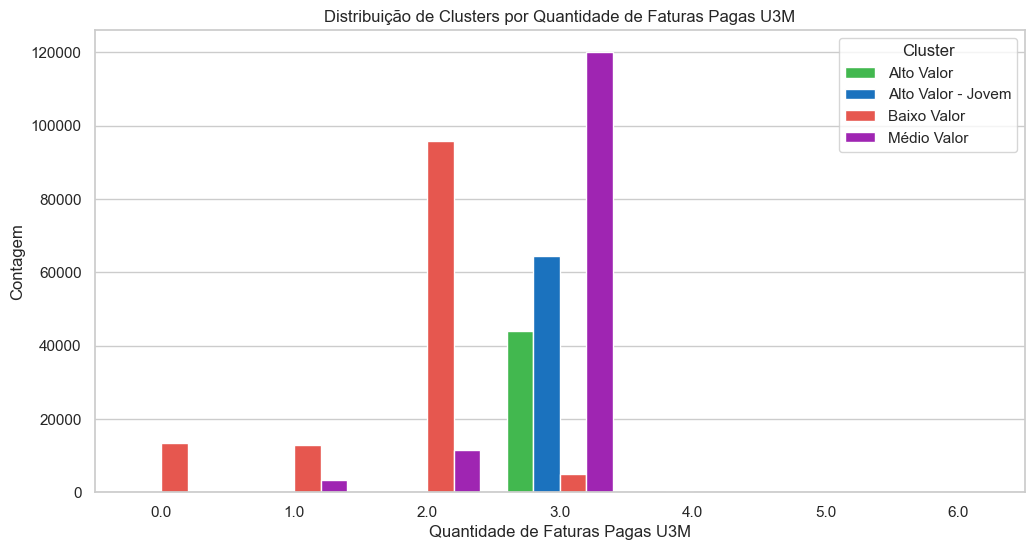

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crie um gráfico de barras empilhadas
sns.set(style="whitegrid")

# Agrupe os dados pelo cluster e conte as ocorrências em cada categoria de "qtd_faturas_pagas_u3m"
cluster_counts = df.groupby(['qtd_faturas_pagas_u3m', 'cluster']).size().unstack(fill_value=0)

# Transforme os dados em um formato adequado para sns.barplot usando a função melt
cluster_counts_melted = cluster_counts.reset_index().melt(id_vars=['qtd_faturas_pagas_u3m'], var_name='Cluster', value_name='Contagem')

# Crie um gráfico de barras empilhadas com sns.barplot
plt.figure(figsize=(12, 6))
sns.barplot(data=cluster_counts_melted, x='qtd_faturas_pagas_u3m', y='Contagem', hue='Cluster', palette=pal)

# Defina rótulos e título
plt.xlabel("Quantidade de Faturas Pagas U3M")
plt.ylabel("Contagem")
plt.title("Distribuição de Clusters por Quantidade de Faturas Pagas U3M")

# Exiba o gráfico
plt.legend(title="Cluster")
plt.show()


### Tempo de base e faturas pagas

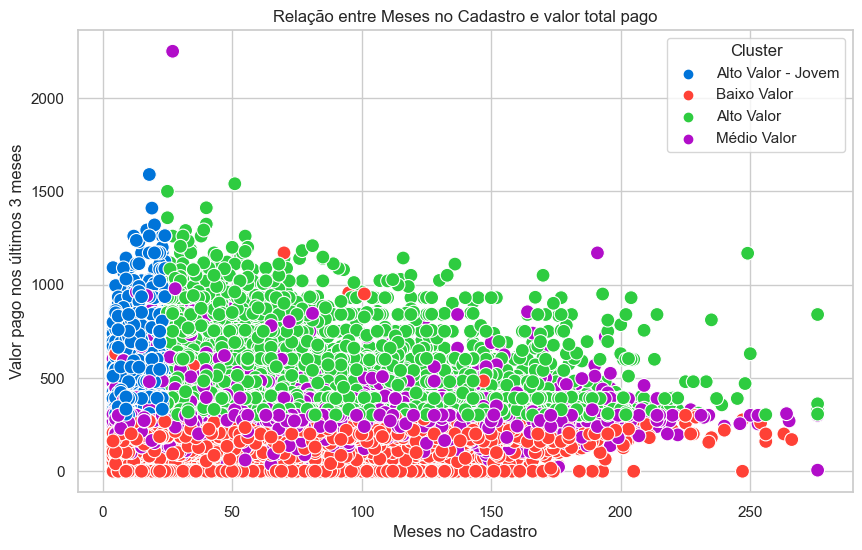

In [ ]:
# Criar um scatterplot relacionando "meses_base_cadastro" com "perc_pago_cobrado_valor" e usar "cluster" como hue
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

sns.scatterplot(data=df, x='meses_base_cadastro', y='total_pago_u3m', hue='cluster', palette=pal, s=100)

# Definir rótulos e título
plt.xlabel("Meses no Cadastro")
plt.ylabel("Valor pago nos últimos 3 meses")
plt.title("Relação entre Meses no Cadastro e valor total pago")

# Exibir o gráfico com legenda
plt.legend(title="Cluster")
plt.show()

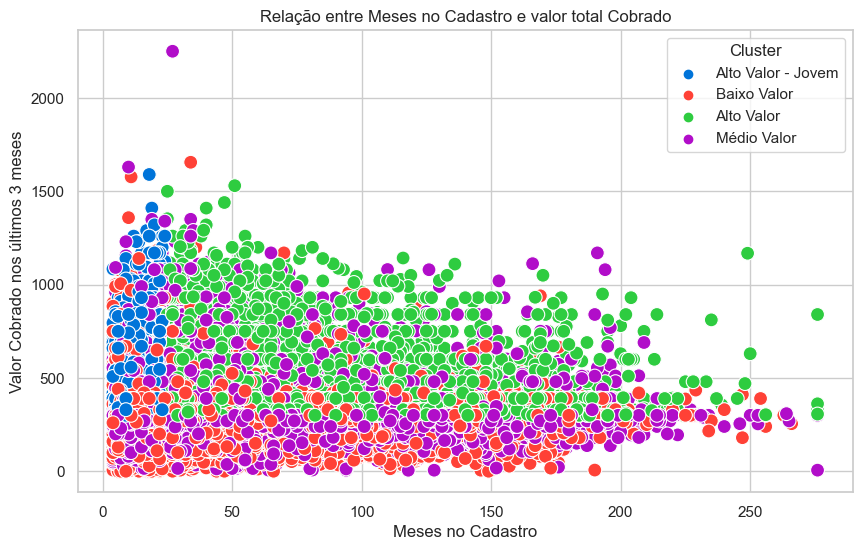

In [ ]:
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

sns.scatterplot(data=df, x='meses_base_cadastro', y='total_cobrado_u3m', hue='cluster', palette=pal, s=100)

plt.xlabel("Meses no Cadastro")
plt.ylabel("Valor Cobrado nos últimos 3 meses")
plt.title("Relação entre Meses no Cadastro e valor total Cobrado")

plt.legend(title="Cluster")
plt.show()

## Ordem de Serviço

In [ ]:
df.groupby('cluster')['qtd_os_finalizadas_u3m'].sum().sort_values(ascending=False)

cluster
Médio Valor           43793
Baixo Valor           35614
Alto Valor              552
Alto Valor - Jovem      522
Name: qtd_os_finalizadas_u3m, dtype: int64

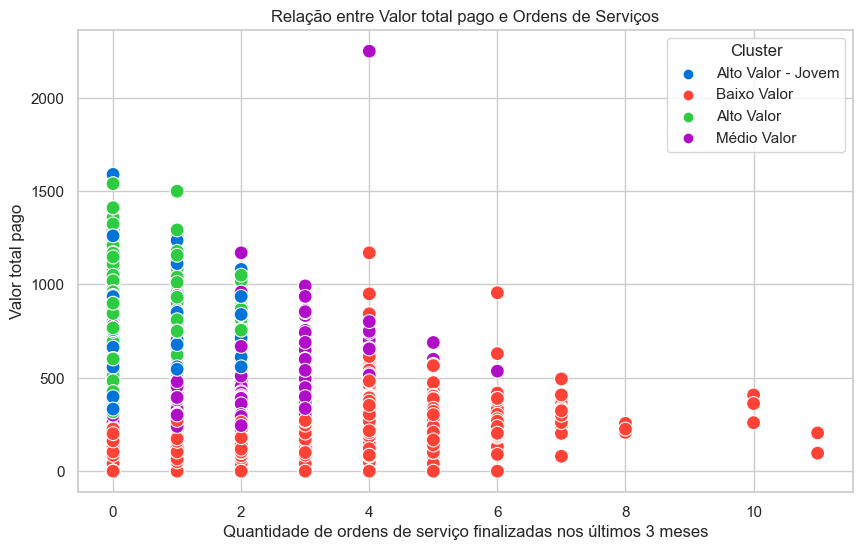

In [ ]:
# Criar um scatterplot relacionando "meses_base_cadastro" com "perc_pago_cobrado_valor" e usar "cluster" como hue
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

sns.scatterplot(data=df, x='qtd_os_finalizadas_u3m', y='total_pago_u3m', hue='cluster', palette=pal, s=100)

# Definir rótulos e título
plt.xlabel("Quantidade de ordens de serviço finalizadas nos últimos 3 meses")
plt.ylabel("Valor total pago")
plt.title("Relação entre Valor total pago e Ordens de Serviços")

# Exibir o gráfico com legenda
plt.legend(title="Cluster")
plt.show()


## Protocolos

In [ ]:
df.groupby('cluster')['qtd_protocolos_u3m'].sum().sort_values(ascending=False)

cluster
Baixo Valor           11217
Médio Valor            8107
Alto Valor - Jovem      133
Alto Valor              118
Name: qtd_protocolos_u3m, dtype: int64

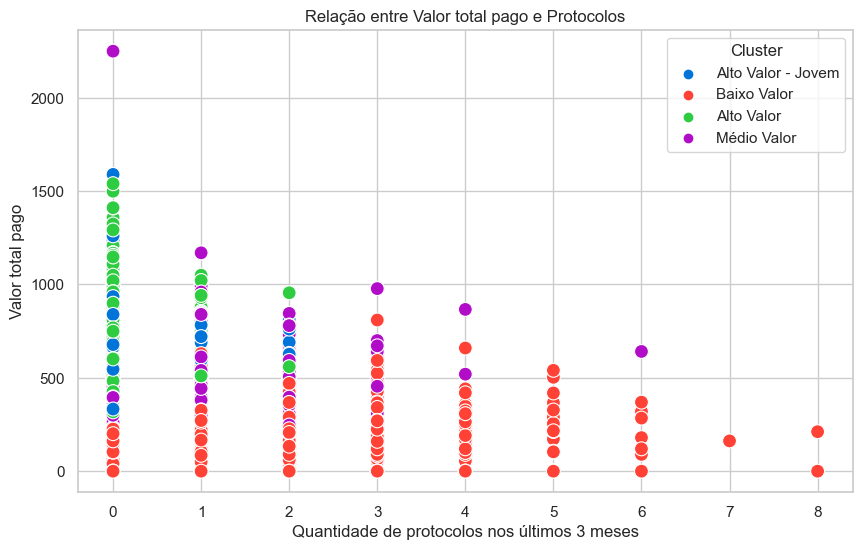

In [ ]:
# Criar um scatterplot relacionando "meses_base_cadastro" com "perc_pago_cobrado_valor" e usar "cluster" como hue
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

sns.scatterplot(data=df, x='qtd_protocolos_u3m', y='total_pago_u3m', hue='cluster', palette=pal, s=100)

# Definir rótulos e título
plt.xlabel("Quantidade de protocolos nos últimos 3 meses")
plt.ylabel("Valor total pago")
plt.title("Relação entre Valor total pago e Protocolos")

# Exibir o gráfico com legenda
plt.legend(title="Cluster")
plt.show()


## Separando com e sem desconto de cada cluster

In [ ]:
def criar_coluna_cluster_desconto(row):
    if row['possui_desconto'] == 1:
        desconto = "C_desc"
    else:
        desconto = "S_desc"

    cluster_desconto = f"{row['cluster']}_{desconto}"
    return cluster_desconto

df['cluster_desconto'] = df.apply(criar_coluna_cluster_desconto, axis=1)

In [ ]:
#Separando em dataframes com e sem desconto 
mascara = df['cluster_desconto'].str.contains('C_desc', case=False)
clientes_com_desconto = df.loc[mascara]

mascara = df['cluster_desconto'].str.contains('S_desc', case=False)
clientes_sem_desconto = df.loc[mascara]

### Pessoas Sem Desconto

In [ ]:
grupo = clientes_sem_desconto.groupby('cluster_desconto')[['total_pago_u3m', 'total_cobrado_u3m','qtd_faturas_cobradas_u3m','qtd_faturas_pagas_u3m']].sum()
resultado_perc_pago = grupo['total_pago_u3m'] / grupo['total_cobrado_u3m']
resultado_perc_pago_quantidade = grupo['qtd_faturas_pagas_u3m'] / grupo['qtd_faturas_cobradas_u3m']

resultado_df = pd.DataFrame({'Resultado_Perc_Pago_valor': resultado_perc_pago, 
                            'Resultado_Perc_Pago_Quantidade': resultado_perc_pago_quantidade})
resultado_df = resultado_df.reset_index()
resultado_df.sort_values('Resultado_Perc_Pago_valor', ascending=False)


,cluster_desconto,Resultado_Perc_Pago_valor,Resultado_Perc_Pago_Quantidade
0,Alto Valor - Jovem_S_desc,1.009046,0.999663
1,Alto Valor_S_desc,1.006086,0.999718
3,Médio Valor_S_desc,0.973521,0.975296
2,Baixo Valor_S_desc,0.600297,0.598658


In [ ]:
df_teste = clientes_sem_desconto.groupby('cluster_desconto').agg({'total_pago_u3m': 'sum', 'num_adm': 'count'}).reset_index()
df_teste = df_teste.rename(columns={'total_pago_u3m': 'total_pago_u3m_sum', 'num_adm': 'Qtd Clientes'})

df_teste['CAC'] = df_teste['Qtd Clientes'] * 1000

df_teste['percentual_pago_CAC'] = df_teste['total_pago_u3m_sum'] / df_teste['CAC']   

df_teste = df_teste.sort_values('percentual_pago_CAC', ascending= False)
df_teste


,cluster_desconto,total_pago_u3m_sum,Qtd Clientes,CAC,percentual_pago_CAC
1,Alto Valor_S_desc,13549984.96,37813,37813000,0.358342
0,Alto Valor - Jovem_S_desc,16787060.62,47404,47404000,0.354128
3,Médio Valor_S_desc,21838548.26,75163,75163000,0.290549
2,Baixo Valor_S_desc,15142178.06,79149,79149000,0.191312


In [ ]:
# Mapeie clusters para as paletas correspondentes
pal = {
    'Baixo Valor_S_desc': '#FF4136',
    'Médio Valor_S_desc': '#B10DC9',
    'Alto Valor_S_desc': '#2ECC40',
    'Alto Valor - Jovem_S_desc': '#0074D9'
}


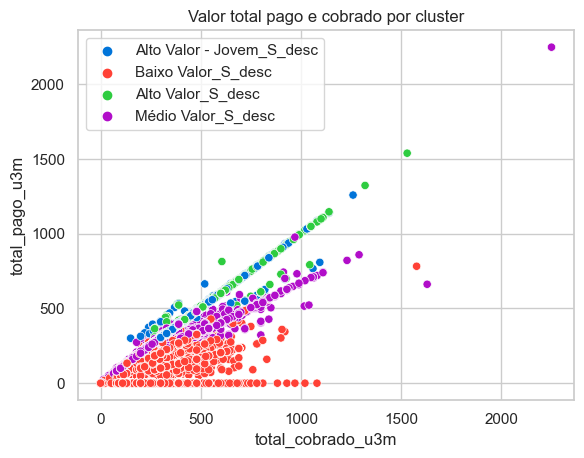

In [ ]:
pl = sns.scatterplot(data = clientes_sem_desconto,x=clientes_sem_desconto["total_cobrado_u3m"],
                      y=clientes_sem_desconto["total_pago_u3m"],hue=clientes_sem_desconto["cluster_desconto"], palette= pal)
pl.set_title("Valor total pago e cobrado por cluster")
plt.legend()

plt.show()

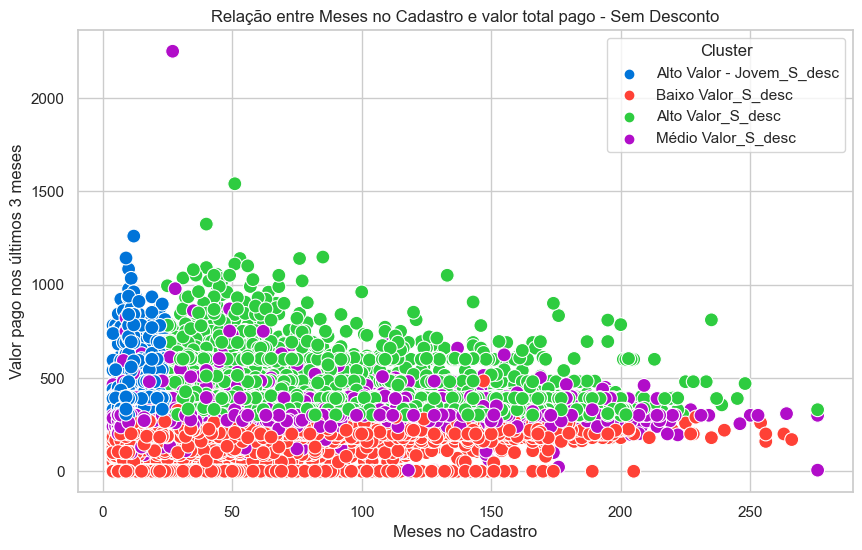

In [ ]:
# Criar um scatterplot relacionando "meses_base_cadastro" com "perc_pago_cobrado_valor" e usar "cluster" como hue
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

sns.scatterplot(data=clientes_sem_desconto, x='meses_base_cadastro', y='total_pago_u3m', hue='cluster_desconto', palette=pal, s=100)

# Definir rótulos e título
plt.xlabel("Meses no Cadastro")
plt.ylabel("Valor pago nos últimos 3 meses")
plt.title("Relação entre Meses no Cadastro e valor total pago - Sem Desconto")

# Exibir o gráfico com legenda
plt.legend(title="Cluster")
plt.show()

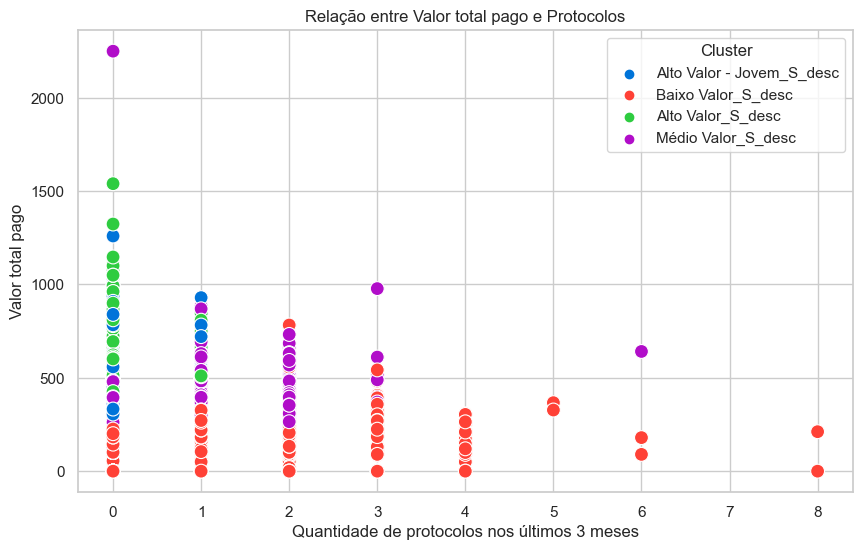

In [ ]:
# Criar um scatterplot relacionando "meses_base_cadastro" com "perc_pago_cobrado_valor" e usar "cluster" como hue
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

sns.scatterplot(data=clientes_sem_desconto, x='qtd_protocolos_u3m', y='total_pago_u3m', hue='cluster_desconto', palette=pal, s=100)

# Definir rótulos e título
plt.xlabel("Quantidade de protocolos nos últimos 3 meses")
plt.ylabel("Valor total pago")
plt.title("Relação entre Valor total pago e Protocolos")

# Exibir o gráfico com legenda
plt.legend(title="Cluster")
plt.show()


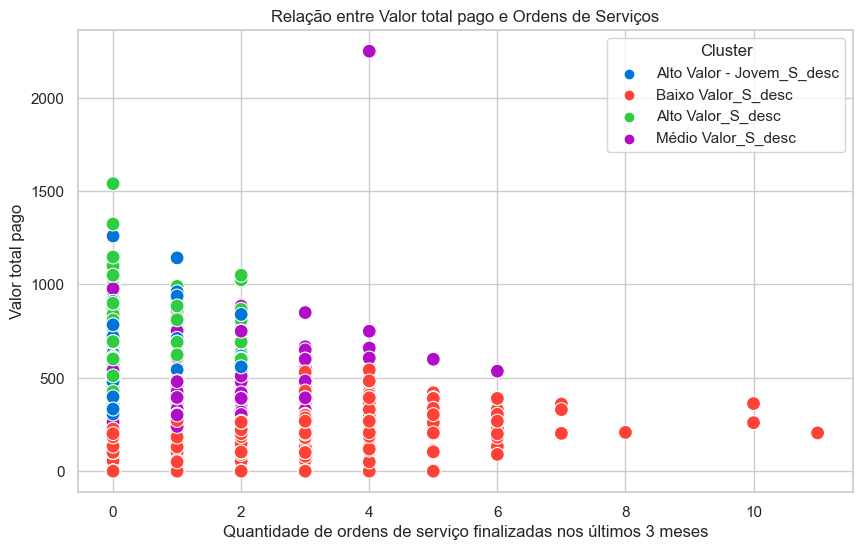

In [ ]:
# Criar um scatterplot relacionando "meses_base_cadastro" com "perc_pago_cobrado_valor" e usar "cluster" como hue
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

sns.scatterplot(data=clientes_sem_desconto, x='qtd_os_finalizadas_u3m', y='total_pago_u3m', hue='cluster_desconto', palette=pal, s=100)

# Definir rótulos e título
plt.xlabel("Quantidade de ordens de serviço finalizadas nos últimos 3 meses")
plt.ylabel("Valor total pago")
plt.title("Relação entre Valor total pago e Ordens de Serviços")

# Exibir o gráfico com legenda
plt.legend(title="Cluster")
plt.show()


### Pessoas com desconto

In [ ]:
#Valor total de pessoas com desconto
clientes_com_desconto.shape[0]

131294

In [ ]:
grupo = clientes_com_desconto.groupby('cluster_desconto')[['total_pago_u3m', 'total_cobrado_u3m','qtd_faturas_cobradas_u3m','qtd_faturas_pagas_u3m']].sum()
resultado_perc_pago = grupo['total_pago_u3m'] / grupo['total_cobrado_u3m']
resultado_perc_pago_quantidade = grupo['qtd_faturas_pagas_u3m'] / grupo['qtd_faturas_cobradas_u3m']

resultado_df = pd.DataFrame({'Resultado_Perc_Pago_valor': resultado_perc_pago, 
                            'Resultado_Perc_Pago_Quantidade': resultado_perc_pago_quantidade})
resultado_df = resultado_df.reset_index()
resultado_df.sort_values('Resultado_Perc_Pago_valor', ascending = False)


,cluster_desconto,Resultado_Perc_Pago_valor,Resultado_Perc_Pago_Quantidade
0,Alto Valor - Jovem_C_desc,1.010982,0.999465
1,Alto Valor_C_desc,1.004732,0.999258
3,Médio Valor_C_desc,0.987910,0.987762
2,Baixo Valor_C_desc,0.576283,0.601075


In [ ]:
df_teste = clientes_com_desconto.groupby('cluster_desconto').agg({'total_pago_u3m': 'sum', 'num_adm': 'count'}).reset_index()
df_teste = df_teste.rename(columns={'total_pago_u3m': 'total_pago_u3m_sum', 'num_adm': 'contagem'})

df_teste['CAC'] = df_teste['contagem'] * 1000

df_teste['percentual_pago_CAC'] = df_teste['total_pago_u3m_sum'] / df_teste['CAC']   

df_teste = df_teste.sort_values('percentual_pago_CAC', ascending= False)
df_teste


,cluster_desconto,total_pago_u3m_sum,contagem,CAC,percentual_pago_CAC
1,Alto Valor_C_desc,2582639.47,6287,6287000,0.410790
0,Alto Valor - Jovem_C_desc,6165206.76,17398,17398000,0.354363
3,Médio Valor_C_desc,16318554.82,59749,59749000,0.273118
2,Baixo Valor_C_desc,7833502.11,47860,47860000,0.163675


In [ ]:
pal = {
    'Baixo Valor_C_desc': '#FF4136',
    'Médio Valor_C_desc': '#B10DC9',
    'Alto Valor_C_desc': '#2ECC40',
    'Alto Valor - Jovem_C_desc': '#0074D9'
}


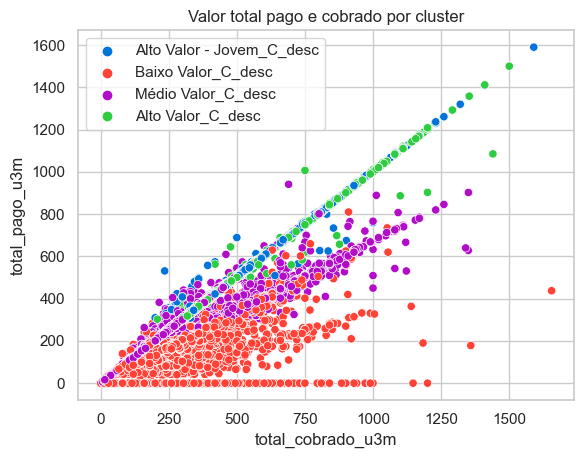

In [ ]:
pl = sns.scatterplot(data = clientes_com_desconto,x=clientes_com_desconto["total_cobrado_u3m"],
                      y=clientes_com_desconto["total_pago_u3m"],hue=clientes_com_desconto["cluster_desconto"], palette= pal)
pl.set_title("Valor total pago e cobrado por cluster")
plt.legend()

plt.show()

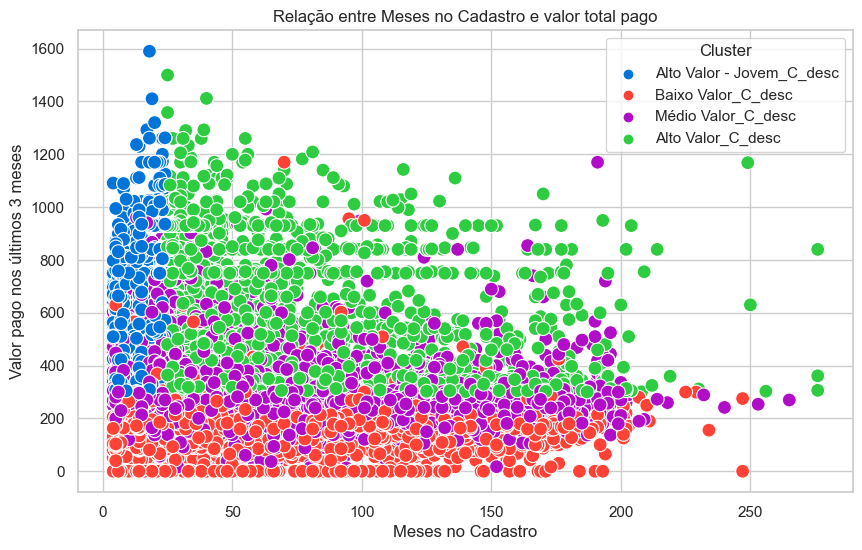

In [ ]:
# Criar um scatterplot relacionando "meses_base_cadastro" com "perc_pago_cobrado_valor" e usar "cluster" como hue
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

sns.scatterplot(data=clientes_com_desconto, x='meses_base_cadastro', y='total_pago_u3m', hue='cluster_desconto', palette=pal, s=100)

# Definir rótulos e título
plt.xlabel("Meses no Cadastro")
plt.ylabel("Valor pago nos últimos 3 meses")
plt.title("Relação entre Meses no Cadastro e valor total pago")

# Exibir o gráfico com legenda
plt.legend(title="Cluster")
plt.show()

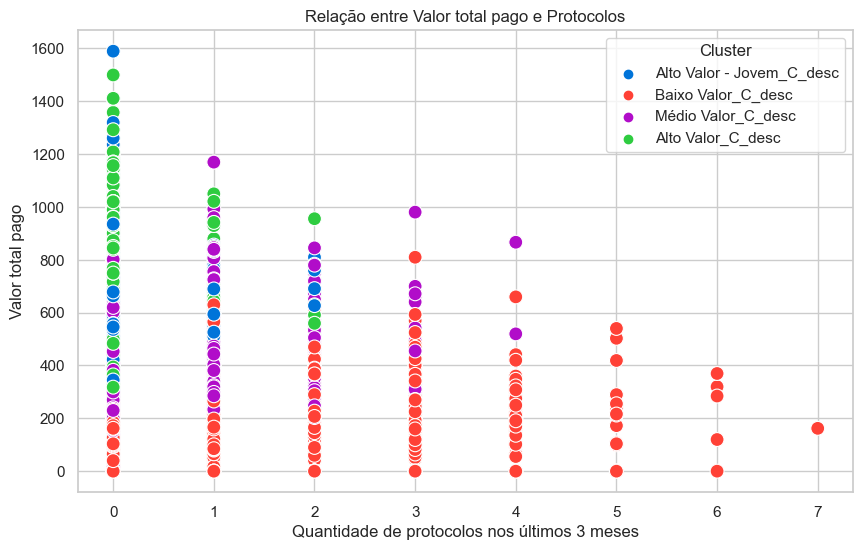

In [ ]:
# Criar um scatterplot relacionando "meses_base_cadastro" com "perc_pago_cobrado_valor" e usar "cluster" como hue
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

sns.scatterplot(data=clientes_com_desconto, x='qtd_protocolos_u3m', y='total_pago_u3m', hue='cluster_desconto', palette=pal, s=100)

# Definir rótulos e título
plt.xlabel("Quantidade de protocolos nos últimos 3 meses")
plt.ylabel("Valor total pago")
plt.title("Relação entre Valor total pago e Protocolos")

# Exibir o gráfico com legenda
plt.legend(title="Cluster")
plt.show()


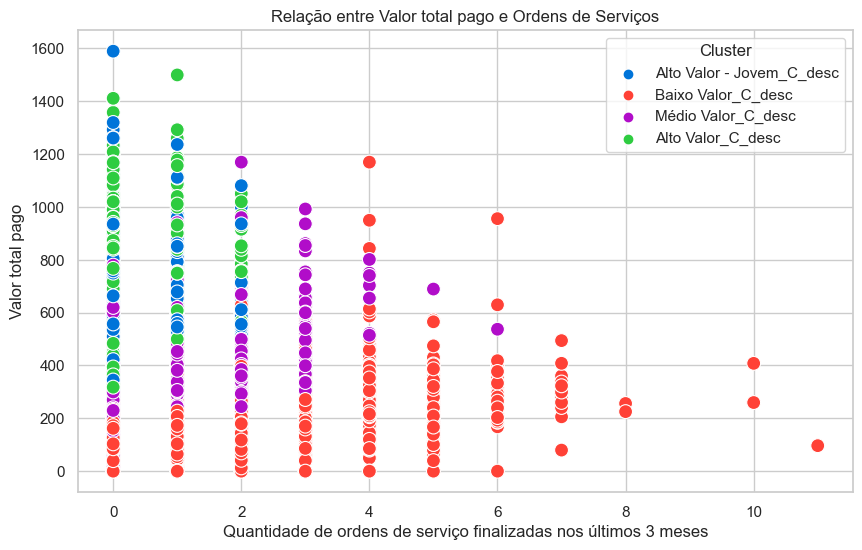

In [ ]:
# Criar um scatterplot relacionando "meses_base_cadastro" com "perc_pago_cobrado_valor" e usar "cluster" como hue
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

sns.scatterplot(data=clientes_com_desconto, x='qtd_os_finalizadas_u3m', y='total_pago_u3m', hue='cluster_desconto', palette=pal, s=100)

# Definir rótulos e título
plt.xlabel("Quantidade de ordens de serviço finalizadas nos últimos 3 meses")
plt.ylabel("Valor total pago")
plt.title("Relação entre Valor total pago e Ordens de Serviços")

# Exibir o gráfico com legenda
plt.legend(title="Cluster")
plt.show()


### Distribuição de Valores pagos

In [25]:
import pandas as pd
df = pd.read_csv(r'Y:\Cobrança\Cris\Churn Voluntário - Modelagem\Segmentação\Versão 2\base_segmentacao_202301_treinamento_V2.csv')

In [26]:
bins = range(0, 1001, 50)

labels = [f"{i}-{i+49}" for i in range(0, 1000, 50)]

df['total_pago_u3m_bins'] = pd.cut(df['total_pago_u3m'], bins=bins, labels=labels, right=False)

count_per_bin = df['total_pago_u3m_bins'].value_counts().sort_index()
display(count_per_bin)

total_pago_u3m_bins
0-49         1069
50-99        6042
100-149     13826
150-199     33580
200-249     59926
250-299    101166
300-349     84804
350-399     39285
400-449      4998
450-499      3279
500-549      1854
550-599      1022
600-649       937
650-699       487
700-749       356
750-799       307
800-849       320
850-899        84
900-949       171
950-999        49
Name: count, dtype: int64

In [23]:
bins = range(-120, 1, 5)
labels = [f"{i} até {i+4}" for i in range(-120, 0, 5)]

df['maior_atraso_u3m_bins'] = pd.cut(df['maior_atraso_u3m'], bins=bins, labels=labels, right=False)

count_per_bin = df['maior_atraso_u3m_bins'].value_counts().sort_index()

display(count_per_bin)


maior_atraso_u3m_bins
-120 até -116      162
-115 até -111      161
-110 até -106      176
-105 até -101      183
-100 até -96       371
-95 até -91        431
-90 até -86        562
-85 até -81        771
-80 até -76        554
-75 até -71        535
-70 até -66        739
-65 até -61       1275
-60 até -56       1511
-55 até -51       2127
-50 até -46       3387
-45 até -41       4297
-40 até -36      16214
-35 até -31      29716
-30 até -26      42904
-25 até -21      35666
-20 até -16      19874
-15 até -11      28508
-10 até -6       25214
-5 até -1        49752
Name: count, dtype: int64

In [24]:

bins = range(0, 16, 1)
labels = [f"{i}" for i in range(0, 15, 1)]

df['qt_bloqueio_u3m_bins'] = pd.cut(df['qt_bloqueio_u3m'], bins=bins, labels=labels, right=False)

count_per_bin = df['qt_bloqueio_u3m_bins'].value_counts().sort_index()

display(count_per_bin)


qt_bloqueio_u3m_bins
0     246795
1      50855
2      32337
3      19196
4      10676
5       5319
6       2836
7        910
8        269
9        101
10        46
11         9
12         0
13         1
14         3
Name: count, dtype: int64